# Building a VQA system from scratch

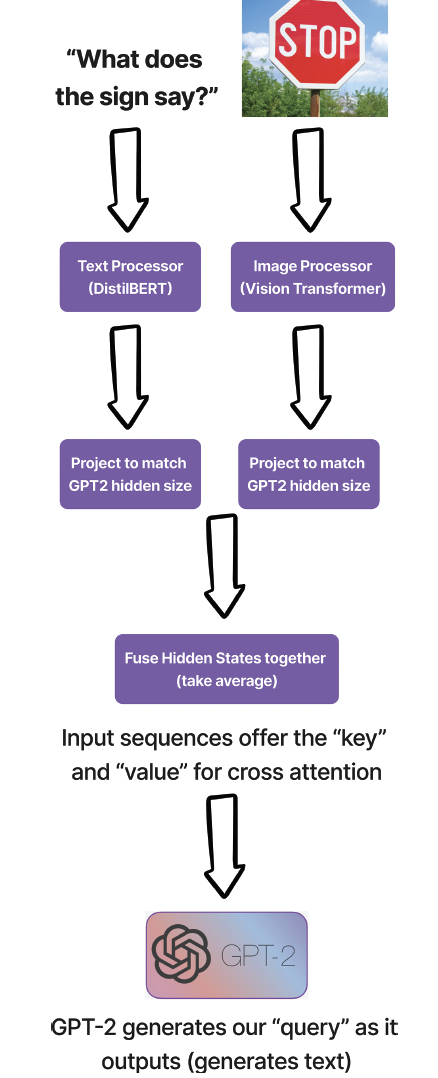

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW

import torch.nn as nn
from transformers import AutoModel, ViTModel, AutoModelForCausalLM, Trainer, TrainingArguments
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

device = torch.device("cuda")
device

device(type='cuda')

In [5]:
import torch
import torch.nn as nn
from transformers import ViTModel, ViTFeatureExtractor, AutoTokenizer, AutoModel, AutoModelForCausalLM


In [6]:
DECODER_MODEL = 'gpt2'
TEXT_ENCODER_MODEL = 'distilbert-base-uncased'
IMAGE_ENCODER_MODEL = "facebook/dino-vitb16"

In [7]:
decoder_tokenizer = AutoTokenizer.from_pretrained(DECODER_MODEL)
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token
image_feature_extractor = ViTFeatureExtractor.from_pretrained(IMAGE_ENCODER_MODEL)

C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [8]:
class MultiModalModel(nn.Module):
    """
    A MultiModalModel class used to perform visual question answering (VQA). 
    It consists of encoders for text and image and a decoder for generating the answer.
    
    Attributes:
        text_encoder: A model to encode text input.
        image_encoder: A model to encode image input.
        decoder: A model to decode and generate answers.
        text_projection: A linear layer to project text encoding to a specific size.
        image_projection: A linear layer to project image encoding to a specific size.
    """

    def __init__(self, text_encoder_model, image_encoder_model, decoder_model, freeze=None, load_from=None):
        """
        Initialize the MultiModalModel.

        Parameters:
            text_encoder_model (str): Pre-trained text encoder model name.
            image_encoder_model (str): Pre-trained image encoder model name.
            decoder_model (str): Pre-trained decoder model name.
            freeze (str, optional): Which parts of the model to freeze. Can be 'encoders', 'decoder', 'all' or specific encoder.
            load_from (str, optional): Path to a checkpoint file to load the model.
        """
        super(MultiModalModel, self).__init__()

        # Initialize text and image encoders
        self.text_encoder = AutoModel.from_pretrained(text_encoder_model)
        self.image_encoder = ViTModel.from_pretrained(image_encoder_model)

        # Initialize the GPT-2 decoder
        self.decoder = AutoModelForCausalLM.from_pretrained(
            decoder_model, add_cross_attention=True, tie_word_embeddings=True
        )

        # Initialize linear layers for projecting encoded features
        self.text_projection = nn.Linear(self.text_encoder.config.hidden_size, self.decoder.config.hidden_size)
        self.image_projection = nn.Linear(self.image_encoder.config.hidden_size, self.decoder.config.hidden_size)
        
        # Freeze specified encoders if required or load from a checkpoint
        if load_from:
            self.load_model_checkpoint(load_from)
        else:
            self.freeze(freeze)

    def freeze(self, freeze):
        """
        Freeze specific parts of the model to prevent them from being updated during training.

        Parameters:
            freeze (str): Which parts to freeze. Can be 'encoders', 'decoder', 'all', or specific encoder.
        """
        if not freeze:
            return

        print('Freezing...')
        if freeze in ('encoders', 'all') or 'text_encoder' in freeze:
            print('Freezing text encoder')
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        if freeze in ('encoders', 'all') or 'image_encoder' in freeze:
            print('Freezing image encoder')
            for param in self.image_encoder.parameters():
                param.requires_grad = False
                
        if freeze in ('decoder', 'all'):
            print('Freezing decoder (except for cross attention)')
            for name, param in self.decoder.named_parameters():
                if "crossattention" not in name:
                    param.requires_grad = False

    def load_model_checkpoint(self, path):
        """
        Load the model from a saved checkpoint.

        Parameters:
            path (str): Path to the saved checkpoint.
        """
        checkpoint = torch.load(path)
        checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
        self.load_state_dict(checkpoint)

    def check_input(self, tensor, tensor_name):
        """
        Check if there are any NaN or infinite values in the input tensor.

        Parameters:
            tensor (torch.Tensor): Input tensor.
            tensor_name (str): Name of the tensor for error logging.
        """
        if torch.isnan(tensor).any() or torch.isinf(tensor).any():
            print(f"NaN or infinite values found in {tensor_name}")

    def encode_text(self, input_text, attention_mask):
        """
        Encode text using the text encoder and project it to a specific size.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.

        Returns:
            torch.Tensor: Projected text encoding.
        """
        self.check_input(input_text, "input_text")
        text_encoded = self.text_encoder(input_text, attention_mask=attention_mask).last_hidden_state.mean(dim=1)
        return self.text_projection(text_encoded)

    def encode_image(self, input_image):
        """
        Encode image using the image encoder and project it to a specific size.

        Parameters:
            input_image (torch.Tensor): Input image tensor.

        Returns:
            torch.Tensor: Projected image encoding.
        """
        self.check_input(input_image, "input_image")
        image_encoded = self.image_encoder(input_image).last_hidden_state.mean(dim=1)
        return self.image_projection(image_encoded)

    def forward(self, input_text, input_image, decoder_input_ids, attention_mask, labels=None):
        """
        Forward pass through the model.

        Parameters:
            input_text (torch.Tensor): Input text tensor.
            input_image (torch.Tensor): Input image tensor.
            decoder_input_ids (torch.Tensor): Decoder input IDs tensor.
            attention_mask (torch.Tensor): Attention mask for the input text.
            labels (torch.Tensor, optional): Ground truth labels for the target.

        Returns:
            torch.Tensor: Decoder output.
        """
        self.check_input(decoder_input_ids, "decoder_input_ids")

        # Encode text and image
        text_projected = self.encode_text(input_text, attention_mask)
        image_projected = self.encode_image(input_image)

        # Combine encoded features
        combined_features = (text_projected + image_projected) / 2
        if labels is not None:
            labels = torch.where(labels == decoder_tokenizer.pad_token_id, -100, labels)

        # Decode with GPT-2
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            labels=labels,
            encoder_hidden_states=combined_features.unsqueeze(1)
        )
        return decoder_outputs

    def generate(self, image, questions, max_text_length=5):
        """
        Generate answers for the given image and list of questions.

        Parameters:
            image (Image): Input image.
            questions (list): List of questions related to the image.
            max_text_length (int, optional): Maximum text length for generated answers.

        Returns:
            Image: Input image.
        """
        # Encode text and image
        image = retrieve_image(image)
        image_input = image_feature_extractor(images=[preprocess_image(image)], return_tensors="pt")
        input_image = image_input["pixel_values"]
        image_projected = self.encode_image(input_image)
            
        for question in questions:
            i = text_tokenizer(question, return_tensors='pt')
            text_projected = self.encode_text(i['input_ids'], i['attention_mask'])
        
            # Combine encoded features
            combined_features = (text_projected + image_projected) / 2

            generated_so_far = torch.LongTensor([[decoder_tokenizer.bos_token_id]])
            with torch.no_grad():
                for _ in tqdm(range(max_text_length)):

                    decoder_outputs = self.decoder(
                        input_ids=generated_so_far,
                        encoder_hidden_states=combined_features.unsqueeze(1)
                    )

                    next_token_logits = decoder_outputs.logits[:, -1, :]
                    next_token_probs = F.softmax(next_token_logits, dim=-1)
                    next_token = next_token_logits.argmax(-1)
                    confidence = next_token_probs[0, next_token].item()
                    print("Next token:", decoder_tokenizer.decode(next_token), "Confidence:", confidence)
                    generated_so_far = torch.cat((generated_so_far, next_token.unsqueeze(0)), dim=1)
            print(question, decoder_tokenizer.decode(generated_so_far[0]))

        return image


In [9]:
text_tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER_MODEL)

In [10]:
from PIL import Image
import torchvision.transforms as T
from transformers import DataCollatorWithPadding
import numpy as np
from PIL import Image

def preprocess_image(image):
    # Open the image if the input is a file path
    if type(image) == str:
        img = Image.open(image)
    else:
        img = image

    # Check the number of channels in the image and convert to RGB if necessary
    if img.mode == 'L':  # 'L' stands for grayscale mode
        img_rgb = img.convert('RGB')
    else:
        img_rgb = img

    return img_rgb

def science_qa_data_collator(batch):
    # Preprocess and tokenize text
    if batch[0].get('answer'):
        text_inputs = [sample['question'] for sample in batch]
    else:
        text_inputs = [f"{sample['question']} Choices are: {', '.join(sample['choices'])}" for sample in batch]
    text_tensors = text_tokenizer(text_inputs, padding=True, return_tensors="pt")
    # Preprocess and tokenize images
    try:
        image_inputs = image_feature_extractor([preprocess_image(sample["image"]) for sample in batch])
    except Exception as e:
        print(e)
        print([sample["image"] for sample in batch])
    image_tensors = torch.from_numpy(np.stack(image_inputs['pixel_values']))
    # Prepare decoder inputs (targets)
    target_inputs = [sample["answer"] for sample in batch]
    target_tensors = decoder_tokenizer(target_inputs, padding=True, return_tensors="pt")
    # Return input tensors
    return {
        "input_text": text_tensors["input_ids"],
        "attention_mask": text_tensors["attention_mask"],
        "input_image": image_tensors,
        "decoder_input_ids": target_tensors["input_ids"],
        "labels": target_tensors["input_ids"]
    }


In [11]:
OUTPUT_DIR = "./vqa_custom"

In [13]:
from PIL import Image
import os
import json
from collections import defaultdict
import numpy as np
from tqdm.auto import tqdm

def retrieve_image(image_file):
    try:
        image = Image.open(image_file)
        return image
    except:
        return None

def load_vqa_data(
    annotations_file, questions_file, images_folder, load_images=False, 
    start_at=None, end_at=None, max_images=None, max_questions=None,
    agree_threshold=5
):
    with open(annotations_file, "r") as f:
        annotations_data = json.load(f)

    with open(questions_file, "r") as f:
        questions_data = json.load(f)

    data = []
    images_used = defaultdict(int)
    # Create a dictionary to map question_id to the annotation data
    annotations_dict = {annotation["question_id"]: annotation for annotation in annotations_data["annotations"]}
    print(len(annotations_dict))
    for question in tqdm(questions_data["questions"][start_at:end_at]):
        question_id = question["question_id"]
        annotation = annotations_dict[question_id]

        image_id = question["image_id"]
        image_file = f"{images_folder}/COCO_{images_folder}_{str(image_id).zfill(12)}.jpg"
        if max_questions and images_used[image_file] >= max_questions:
            continue
        all_answers = [ans["answer"] for ans in annotation["answers"]]
        if all_answers.count(annotation['multiple_choice_answer']) < agree_threshold:
            continue

        if load_images:
            # Load the image and convert it to a numpy array
            image = retrieve_image(image_file)
            if not image:
                continue
            image.close()  # Close the image object
            
        else:
            if not os.path.exists(image_file):
                continue
            # Store the image file path
            image = image_file

        # Add the data as a dictionary
        data.append(
            {
                "image_id": image_id,
                "question_id": question_id,
                "question": question["question"],
                "answer": decoder_tokenizer.bos_token + ' ' + annotation["multiple_choice_answer"]+decoder_tokenizer.eos_token,
                "all_answers": all_answers,
                "image": image,
            }
        )
        images_used[image_file] += 1
        
        if max_images and len(images_used) >= max_images:
            break

    return data


In [14]:
train_data = load_vqa_data(
    "v2_mscoco_train2014_annotations.json", "v2_OpenEnded_mscoco_train2014_questions.json", "train2014",
)

443757


  0%|          | 0/443757 [00:00<?, ?it/s]

In [15]:
train_data[0]

{'image_id': 458752,
 'question_id': 458752000,
 'question': 'What is this photo taken looking through?',
 'answer': '<|endoftext|> net<|endoftext|>',
 'all_answers': ['net',
  'net',
  'net',
  'netting',
  'net',
  'net',
  'mesh',
  'net',
  'net',
  'net'],
 'image': 'train2014/COCO_train2014_000000458752.jpg'}

In [16]:
len(train_data)

359646

In [17]:
import random

random.seed(42)
random.shuffle(train_data)

In [18]:
train_data, val_data = train_data[:300000], train_data[300000:]

In [19]:
len(train_data), len(val_data)

(300000, 59646)

In [20]:
train_dataset = Dataset.from_dict({key: [item[key] for item in train_data] for key in train_data[0].keys()})
val_dataset = Dataset.from_dict({key: [item[key] for item in val_data] for key in val_data[0].keys()})


# Save datasets to disk (optional)
# train_dataset.save_to_disk("vqa_train_dataset")
# val_dataset.save_to_disk("vqa_val_dataset")

In [21]:
v = val_dataset[0]
v

{'image_id': 497350,
 'question_id': 497350001,
 'question': 'Does the animal appear to be agitated?',
 'answer': '<|endoftext|> no<|endoftext|>',
 'all_answers': ['no', 'no', 'no', 'no', 'no', 'no', 'no', 'no', 'yes', 'no'],
 'image': 'train2014/COCO_train2014_000000497350.jpg'}

In [22]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    optim='adamw_torch',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=4,
    evaluation_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,  # only possible if using a GPU
    save_strategy='epoch',
    report_to='wandb'
)

class CustomTrainer(Trainer):
    def __init__(self, *args, train_dataloader=None, eval_dataloader=None, test_dataloader=None, **kwargs):
        super().__init__(*args, **kwargs)
        self._train_dataloader = train_dataloader
        self._eval_dataloader = eval_dataloader
        self._test_dataloader = test_dataloader
    
    def get_train_dataloader(self):
        if self._train_dataloader is not None:
            return self._train_dataloader
        return super().get_train_dataloader()

    def get_eval_dataloader(self, dataset=None):
        if self._eval_dataloader is not None:
            return self._eval_dataloader
        return super().get_eval_dataloader(dataset)

    def get_test_dataloader(self, dataset=None):
        if self._test_dataloader is not None:
            return self._test_dataloader
        return super().get_test_dataloader(dataset)


In [23]:
model = MultiModalModel(
    image_encoder_model=IMAGE_ENCODER_MODEL, text_encoder_model=TEXT_ENCODER_MODEL,
    decoder_model=DECODER_MODEL, freeze='nothing')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and i

Freezing...


In [24]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming you have a `MultiModalModel` instance named `model`
num_trainable_params = count_trainable_parameters(model)
print("Number of trainable parameters:", num_trainable_params)


Number of trainable parameters: 306739968


In [26]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, batch_size=training_args.per_device_train_batch_size, 
    collate_fn=science_qa_data_collator, shuffle=True,
)
eval_dataloader = DataLoader(
    val_dataset, batch_size=training_args.per_device_eval_batch_size, 
    collate_fn=science_qa_data_collator, shuffle=True,
)

warmup_steps = .1 * len(train_dataloader)
training_args.warmup_steps = warmup_steps

# Use the CustomTrainer class
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
)

In [27]:
text_input = text_tokenizer(v['question'], return_tensors="pt").to('cuda')
input_text = text_input["input_ids"].to('cuda')
attention_mask = text_input["attention_mask"].to('cuda')

decoder_input = decoder_tokenizer(v['answer'], return_tensors="pt", add_special_tokens=False)
decoder_input_ids = decoder_input["input_ids"].to('cuda')
print('answer ||', v['answer'])
print('decoder_input_ids', decoder_input_ids)
image_input = image_feature_extractor(images=[preprocess_image(retrieve_image(v['image']))], return_tensors="pt")
input_image = image_input["pixel_values"].to('cuda')

model_output = model(input_text, input_image, decoder_input_ids, attention_mask, labels=decoder_input_ids)
output_ids = torch.argmax(model_output.logits, dim=-1)
print('model ouput ids', output_ids)
# Decode the token IDs into text
decoded_output = decoder_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(model_output.loss)
print("Decoded output:", decoded_output)

answer || <|endoftext|> no<|endoftext|>
decoder_input_ids tensor([[50256,   645, 50256]], device='cuda:0')
model ouput ids tensor([[198,  62, 464]], device='cuda:0')
tensor(11.3987, device='cuda:0', grad_fn=<NllLossBackward0>)
Decoded output: 
_The


In [28]:
import wandb


In [29]:
trainer.evaluate()

C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


wandb: Currently logged in as: profoz. Use `wandb login --relogin` to force relogin


{'eval_loss': 11.994693756103516,
 'eval_runtime': 2023.6835,
 'eval_samples_per_second': 29.474,
 'eval_steps_per_second': 0.921}

In [30]:
trainer.train()

C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Epoch,Training Loss,Validation Loss
0,1.817700,1.790510
1,1.589900,1.606807


C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


TrainOutput(global_step=9374, training_loss=2.089809449924089, metrics={'train_runtime': 42536.0773, 'train_samples_per_second': 14.106, 'train_steps_per_second': 0.22, 'total_flos': 0.0, 'train_loss': 2.089809449924089, 'epoch': 2.0})

In [31]:
trainer.evaluate()

C:\Users\sinan\anaconda3\envs\Torch2\Lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.6146777868270874,
 'eval_runtime': 1784.2686,
 'eval_samples_per_second': 33.429,
 'eval_steps_per_second': 1.045,
 'epoch': 2.0}

In [32]:
trainer.save_model()